# **[Chapter 02]**  
**┗ 당뇨 환자 병원 재방문 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「Error analysis」
* 🥇Session 3 - 「주제그룹 분석」

In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/00.fast_campus/00.HyperDifference/03.Part4/Chapter02")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/00.fast_campus/00.HyperDifference/03.Part4/Chapter02'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🏭

```
당뇨병은 세계 성인 인구의 9% 이상에 영향을 미치고 있으며, 점점 더 증가하고 있다. 
당뇨 환자는 지속적인 관찰과 치료가 필요하며, 중증 환자는 더 세심한 관리가 필요하다. 
일단, 우리의 목적은 30일 이내에 재입원해야 하는 환자를 예측하는 모델을 생성하는 것이다.
병원에서 중증 환자의 모니터링, 조기 예약, 간호사 호출과 같은 예방 조치를 더 많이 취할 수 있다고 생각해보자. 
이는, 많은 생명을 구할 수 있는 일이 될지도 모른다. 
우리는 당뇨 환자의 재입원을 예측하는 모델을 만들어보고, 모델의 성능 향상을 위해 에러의 분포를 분석하여 성능을 향상시켜보자.
```



In [ ]:
# openml API를 사용하여 당뇨 환자 데이터 읽어오기
from sklearn.datasets import fetch_openml
X_orig, y = fetch_openml(data_id=43874, as_frame=True, return_X_y=True)

In [ ]:
X_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hospital          101766 non-null  float64 
 6   medical_specialty         101766 non-null  object  
 7   num_lab_procedures        101766 non-null  float64 
 8   num_procedures            101766 non-null  float64 
 9   num_medications           101766 non-null  float64 
 10  primary_diagnosis         101766 non-null  object  
 11  number_diagnoses          101766 non-null  float64 
 12  max_glu_serum             101766 non-null  object  
 13  A1Cresult                 101

> **데이터 살펴보기**

* 환자 입원 당시 측정 데이터
* 데이터 명세 ⬇ 

|Column|Description|
|:---|:---|
|Features|환자 입원 기간 내 관련 정보|
|Class|readmit_30_days|

In [ ]:
# 각 컬럼별로 값을 실제로 확인해본다. 
X_orig.sample(n=5)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
59606,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,1.0,InternalMedicine,47.0,0.0,17.0,...,Steady,Ch,Yes,False,False,True,False,False,>30,1.0
45263,AfricanAmerican,Female,Over 60 years,Other,Other,4.0,InternalMedicine,49.0,1.0,20.0,...,Up,Ch,Yes,True,False,True,False,False,>30,1.0
64535,Caucasian,Male,Over 60 years,Discharged to Home,Referral,4.0,Cardiology,35.0,2.0,39.0,...,Up,Ch,Yes,False,False,False,False,False,NO,0.0
60639,Caucasian,Female,Over 60 years,Other,Emergency,1.0,InternalMedicine,35.0,0.0,16.0,...,No,No,No,True,False,False,False,False,NO,0.0
50943,AfricanAmerican,Female,Over 60 years,Other,Referral,4.0,Other,43.0,2.0,17.0,...,Down,Ch,Yes,True,False,False,False,False,<30,1.0



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 퇴원한 환자들 중에 다시 입원하는 환자들이 늘어남
```  

> **기대효과**

```
▶ 재입원 환자 예측을 통해 중증 환자 사전 조치 및 모니터링
▶ 중증 환자 생존율 증가
```

> **해결방안**

```
▶ Binary classification을 통해 30일 이내 재입원할 환자를 분류
▶ Session 1 🥉
 - 인코딩을 통한 데이터 준비
 - 베이스 모델 생성하기
▶ Session 2 🥈
 - Class weight가 오류에 미치는 영향 분석
 - 하이퍼파라미터 튜닝
▶ Session 3 🥇
 - 에러를 서로 다른 주제 그룹으로 나눠보기
 - Feature importance 알아보기

기타: 에러를 줄일 수 있는 몇가지 방법에 대한 이야기
```

> **성과측정**  

```
▶ 에러 분석을 통한 점진적 성능 향상
```

> **현업적용**  

```
▶ 모델 성능 하락시 분석 포인트 탐색
```

> **주요 핵심 미리 살펴보기**  

```
▶ Session 1 → OneHotEncoder를 활용한 Feature 생성
▶ Session 2 → LightGBMClassifier를 활용한 베이스 모델 생성, optuna를 활용한 Hyperparameter 튜닝
▶ Session 3 → 일반적인 에러 분석, Cohort 에러 분석
```

## **Data Spec Check**
---
> **Data 가공 명세서** 

<img src = "https://drive.google.com/uc?id=10ghjKrqQWBHS4dYzol3IIU1CzJ_vv4Ih">

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### 1-0. 몇 가지 필요한 Library 설치

In [ ]:
!pip install raiwidgets lightgbm optuna shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.3/784.3 KB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 1-1. 필요한 패키지 Import

In [ ]:
import math
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)  


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb
import optuna

from responsibleai import RAIInsights
from raiwidgets import ResponsibleAIDashboard
from raiwidgets.cohort import Cohort, CohortFilter, CohortFilterMethods
import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

### 1-2. Target 유의 변수 제거

_Target 변수와 상관관계가 높은 feature 2개를 제거한다_

In [ ]:
X_orig['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [ ]:
X_orig['readmit_binary'].value_counts()

0.0    54864
1.0    46902
Name: readmit_binary, dtype: int64

_Actual Target_

In [ ]:
y.value_counts()

0.0    90409
1.0    11357
Name: readmit_30_days, dtype: int64

```
위에서 보면 알 수 있듯이 2개의 변수는 y와 직접적으로 상관관계가 보이므로 학습 Feature에 사용할 수 없다. 
y와 직접적으로 상관관계가 있는 변수를 feature로 사용할 경우, 모든 경우에 100%에 가까운 정확도를 보이게 되며
이는 정답을 보여주는 것과 같기 때문에 정상적인모델이라고 할 수 없다.
```

### 1-3. 인코딩을 통한 데이터 준비

In [ ]:
#인코딩을 위한 함수 정의
def transform_data(X_):
    #Remove alternative target columns
    X = X_.drop(['readmitted', 'readmit_binary'], axis=1)

    #Binary encode boolean columns
    bool_cols_l = X.select_dtypes(include=["category"]).columns.tolist()
    X[bool_cols_l] = X[bool_cols_l].astype(str).replace({"True":1, "False":0})
    print(bool_cols_l)

    #One hot encode categorical columns
    cat_cols_l = X.select_dtypes(include=["object"]).columns.tolist()
    print(cat_cols_l)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_np = ohe.fit_transform(X[cat_cols_l].astype("category"))
    X[ohe.get_feature_names(cat_cols_l)] = ohe_np.astype(int)

    #Drop original categorical columns
    X.drop(cat_cols_l, axis=1, inplace=True)

    return X

In [ ]:
X = transform_data(X_orig)

['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
['race', 'gender', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']


In [ ]:
print(f"Number of Features: {len(X_orig.columns)}")
print(X_orig.columns)

Number of Features: 24
Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')


In [ ]:
print(f"Number of Features(After processing): {len(X.columns)}")
print(X.columns)

Number of Features(After processing): 54
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_30 years or younger', 'age_30-60 years',
       'age_Over 60 years', 'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Genitourinary Is

### 1-4. 데이터셋 분할

In [ ]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

In [ ]:
classes_l = ['NO or > 30 days', '< 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=rand)
X_orig_test = X_orig.loc[X_test.index]

In [ ]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
15992,10.0,45.0,0.0,14.0,9.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
10606,4.0,39.0,0.0,11.0,5.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
64779,1.0,37.0,2.0,7.0,5.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
83257,8.0,45.0,0.0,24.0,9.0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
4204,12.0,51.0,0.0,12.0,7.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,2.0,35.0,0.0,12.0,9.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
54886,5.0,63.0,2.0,23.0,9.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1
76820,3.0,55.0,1.0,33.0,9.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
860,12.0,77.0,2.0,21.0,9.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1


In [ ]:
X_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
35956,11.0,68.0,0.0,20.0,5.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
60927,1.0,20.0,0.0,7.0,8.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
79920,4.0,21.0,3.0,23.0,7.0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
50078,12.0,28.0,0.0,19.0,7.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
44080,1.0,21.0,0.0,6.0,7.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19901,1.0,45.0,1.0,5.0,4.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
9561,4.0,58.0,0.0,10.0,9.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
47211,2.0,68.0,6.0,16.0,9.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
25232,6.0,61.0,2.0,7.0,5.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0


### 1-5. Modeling 및 Evaluation 함수 정의
모델을 생성하면 성능에 대한 평가를 위해 evaluation 함수를 정의하고 시작하는 것이 좋다. 
여기에서는 일반적으로 평가척도에서 많이 사용되는 Accuracy, Precision, Recall, F1 score를 구하는 evaluation 함수를 작성하여 사용하도록 하자. 
이 함수는 Confusion Matrix를 Heatmap으로 그리는 것도 포함한다.


### 1-6. Evaluation 함수 정의

In [ ]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    roc_auc_te = metrics.roc_auc_score(y_test, y_test_prob)

    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc_tr = metrics.accuracy_score(y_train, y_train_pred)
    acc_te = metrics.accuracy_score(y_test, y_test_pred)
    pre_te = metrics.precision_score(y_test, y_test_pred)
    rec_te = metrics.recall_score(y_test, y_test_pred)
    f1_te = metrics.f1_score(y_test, y_test_pred)
    mcc_te = metrics.matthews_corrcoef(y_test, y_test_pred)

    if plot:
        print(f"Accuracy_train:  {acc_tr:.4f}\t\tAccuracy_test:   {acc_te:.4f}")
        print(f"Precision_test:  {pre_te:.4f}\t\tRecall_test:     {rec_te:.4f}")
        print(f"ROC-AUC_test:    {roc_auc_te:.4f}\t\tF1_test:         {f1_te:.4f}\t\tMCC_test: {mcc_te:.4f}")
        plt.figure(figsize=(6, 5))
        if pct:
            ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            ax = sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Observed', fontsize=12)
        plt.show()

        return y_train_pred, y_test_prob, y_test_pred
    else:
        t = cf_matrix.sum()
        metrics_dict = {'accuracy_train':acc_tr , 'accuracy_test':acc_te, 'precision':pre_te, 'recall':rec_te,\
                      'roc_auc':roc_auc_te,  'f1':f1_te, 'mcc': mcc_te, 'tn%':tn/t, 'fp%':fp/t, 'fn%':fn/t, 'tp%':tp/t }
        return metrics_dict

### 1-7. Base 모델 학습

Accuracy_train:  0.8888		Accuracy_test:   0.8877
Precision_test:  0.0000		Recall_test:     0.0000
ROC-AUC_test:    0.6479		F1_test:         0.0000		MCC_test: -0.0029


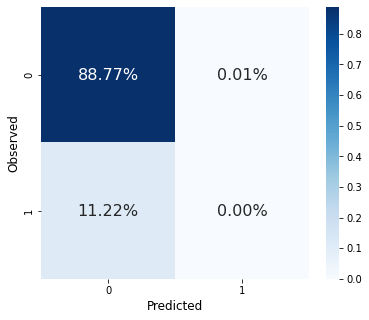

In [ ]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1)
clf.fit(X_train, y_train)

_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

숫자만 봤을 때는 정확도는 매우 높은 것으로 보이지만, 
Precision과 Recall은 매우 낮아 전반적인 성능은 나쁘다.

#### 1-7-1. Class Weights


모델은 기본적으로 Positive 클래스를 예측할 때 보수적 접근 방법으로 모델을 생성하기 떄문에 너무 많은 위험을 감수하지 않는다.
해결책은 Positive 클래스에 더 많은 비중을 두도록 강제하는 Hyperparameter를 활용하는 것이다. 
클래스 가중치를 부여할 수 있는 방법은 여러 가지가 있지만, 그 중 하나인 `scale_pos_weight`를 활용해보자. 

보통 많이 사용하는 값은 아래 수식을 통해 계산한다.

$\large{\frac{\text{number of negative samples}}{\text{number of positive samples}}}$

In [ ]:
def_scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f"default scale pos weight: {def_scale_pos_weight:.2f}")

default scale pos weight: 7.96


이 값은 실제로 모델의 성능을 향상시키지만 여전히 상당한 수준의 오탐지가 존재한다.

Accuracy_train:  0.6431		Accuracy_test:   0.6138
Precision_test:  0.1659		Recall_test:     0.6067
ROC-AUC_test:    0.6445		F1_test:         0.2606		MCC_test: 0.1420


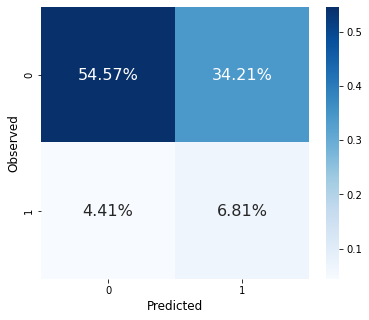

In [ ]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight)
clf.fit(X_train, y_train)
_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

그리고 두 배로 만들면 오탐지가 두 배가 된다.

Accuracy_train:  0.3329		Accuracy_test:   0.3115
Precision_test:  0.1281		Recall_test:     0.8844
ROC-AUC_test:    0.6449		F1_test:         0.2237		MCC_test: 0.0933


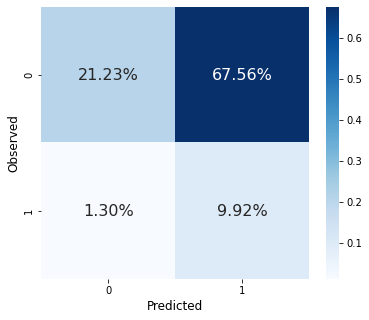

In [ ]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight*2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

그리고 절반으로 줄이면 반대로 모델이 더 보수적으로 바뀐다.

Accuracy_train:  0.8787		Accuracy_test:   0.8623
Precision_test:  0.2250		Recall_test:     0.0931
ROC-AUC_test:    0.6478		F1_test:         0.1317		MCC_test: 0.0789


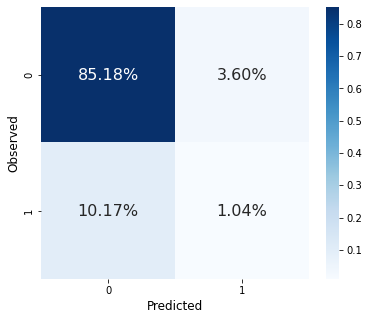

In [ ]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight/2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

#### 1-7-2. Hyperparameter tuning

보수적 접근 방법은 다음과 같은 특징 때문에 실제 적용이 너무 어렵다.

- True Positive(정탐)만 Maximize
- False Positive(미탐) 최소화
- 보통은 Recall이나 Precision을 더 선호
- 미탐보다 오탐이 훨씬 더 많음

현재 모델의 결과를 보면, 거의 모든 것이 Positive 클래스에 속할 것으로 예상되는 문제가 있다.

이를 해결하기 위해 몇 가지 제약 조건을 정의해야 한다. 
예를 들어, 재입원하지 않은 모든 데이터을 포함할 수 있도록 적어도 충분한 true negative(정음성)이 있어야한다.

In [ ]:
min_tn = X_orig[X_orig['readmitted']=='NO'].shape[0] / X_orig.shape[0]
print(f"Patients % that never readmitted (Minimum % of True Negatives): {min_tn:.2%}")

Patients % that never readmitted (Minimum % of True Negatives): 53.91%


또한 우리는 30일이 지나서 재입원한 환자도 False Positive에 포함되도록 비율을 조정해야 한다.

In [ ]:
max_fp = X_orig[X_orig['readmitted']=='>30'].shape[0] / X_orig.shape[0]
print(f"Patients % that were readmitted over 30 days later (Maximum % of False Positives): {max_fp:.2%}")

Patients % that were readmitted over 30 days later (Maximum % of False Positives): 34.93%


**Define optimization fuction**

함수에서 `scale_pos_weight`를 사용한 클래스 가중치 외에도 `max_depth`(트리 깊이를 제한하기 위해) 및 `reg_lambda` 및 `reg_alpha`를 사용한 L1/L2 정규화에 대한 최상의 하이퍼파라미터를 찾습니다. 이렇게 하면 모델이 일반화되는 데 도움이 됩니다. 목적 함수는 두 제약 조건이 충족되지 않는 경우를 제외하고 `recall`을 출력합니다. 이 경우 0을 반환합니다.

In [ ]:
def optimize_lgb(trial): 
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 11),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight/2, def_scale_pos_weight*2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
    }
    if params['max_depth'] == 11:
        params['max_depth'] = -1

    clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **params)
    clf.fit(X_train, y_train)

    metrics_dict = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test, plot=False)

    if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp):
        return 0

    return metrics_dict['recall']

**Run optimization trials**

`optuna`로 100번의 시도를 실행하는 데 몇 분 정도 걸린다.

In [ ]:
%%time
opt_study = optuna.create_study(direction='maximize')
opt_study.optimize(optimize_lgb, n_trials=100)

[I 2023-02-12 04:21:00,819] A new study created in memory with name: no-name-bab30599-ee73-45fb-addb-c615fbd2c113
[I 2023-02-12 04:21:03,188] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 10.9141671148606, 'reg_lambda': 0.04628466484621964, 'reg_alpha': 0.08393166425202055}. Best is trial 0 with value: 0.0.
[I 2023-02-12 04:21:04,410] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 12.761818909972082, 'reg_lambda': 0.00022578358128928143, 'reg_alpha': 0.0003476049051655577}. Best is trial 0 with value: 0.0.
[I 2023-02-12 04:21:06,062] Trial 2 finished with value: 0.5556204379562044 and parameters: {'max_depth': 10, 'scale_pos_weight': 7.214595258191652, 'reg_lambda': 4.6992166259821613e-07, 'reg_alpha': 4.1577379808432116e-07}. Best is trial 2 with value: 0.5556204379562044.
[I 2023-02-12 04:21:07,775] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 14.264937125777127, '

CPU times: user 5min 55s, sys: 4.7 s, total: 6min
Wall time: 3min 55s


`study`가 끝나면 다음과 같이 최상의 결과를 얻을 수 있는 `model hyperparameter`를 출력할 수 있다.

In [ ]:
best_params = opt_study.best_params
print(best_params)

{'max_depth': 4, 'scale_pos_weight': 7.687847660573682, 'reg_lambda': 1.2481827996825933e-07, 'reg_alpha': 6.217363714063122e-06}


실습을 따라하시는 분들은 다른 결과가 출력되었을 수도 있다. 실습의 일관성을 유지하기 위해 덮어쓰도록 한다.

In [ ]:
best_params = {'max_depth': 4, 'scale_pos_weight': 7.687847660573682, 'reg_lambda': 1.2481827996825933e-07,\
               'reg_alpha': 6.217363714063122e-06}

#### 1-7-3 Train Tuned Model

Accuracy_train:  0.6208		Accuracy_test:   0.6099
Precision_test:  0.1665		Recall_test:     0.6181
ROC-AUC_test:    0.6503		F1_test:         0.2623		MCC_test: 0.1453


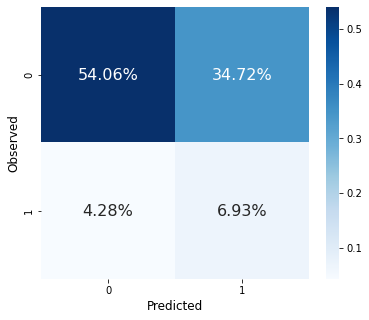

In [ ]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         **best_params)
clf.fit(X_train, y_train)

_, y_prob, y_pred = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

# **🥈Session 2**  
**┗ Error analysis**  
---

## 2) Error Analysis 소개

### 2-1. 현재까지의 결과가 최선일까?

`Confusion Matrix`를 자세히 살펴보면 `False Positive`보다 `True Positive`가 60% 더 많지만 `False Positive`가 결과적으로 더 심각한 비용을 발생시킨다.
그러나 우리가 설정한 제약으로 인해 `True Positive`의 절반 이상이 결국 재입원으로 분류될 것다. (30일 이상 지난 환자도 재분류하는 제약)

In [ ]:
X_orig_test['readmitted'].value_counts()

NO     16461
>30    10644
<30     3425
Name: readmitted, dtype: int64

대부분의 모델 목표가 30일 이상 재입원을 예상하므로 긍정적인 클래스가 이 그룹을 독점적으로 나타낸다. 
30일 이상 재입원 하지 않은 것에 대한 `False Positive` 오분류는 `NO` 에 대한 오분류만큼 나쁘지 않다. 
그렇다면 30일 이후 재입원에 대한 오탐지 비율은 얼마일까요?

In [ ]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred})
preds_df[(preds_df.y_true==0) & (preds_df.y_pred==1)].value_counts(normalize=True)

readmitted  y_true  y_pred
NO          0       1         0.504103
>30         0       1         0.495897
dtype: float64

실제로 오탐지의 거의 절반(전체 테스트 샘플의 34.72%)이 결국 재입원하였으므로 사전 예방 조치를 취하는 것이 나쁜 것이 아니라고 판단된다. 
우리가 고려해야 할 잘못된 결과는 나머지 절반에 대한 부분이다.

### 2-2. Error를 주제 그룹으로 나눠보자

#### 2-2-1. Error를 그룹별로 비교해보기 위해 함수를 하나 만들어보자

In [ ]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc, fnr, fpr = np.nan, np.nan, np.nan
    if len(np.unique(s.y_true)) == 2:
        roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
        tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
        fnr = (fn/(tp+fn)) * 100
        fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                 index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):

    print(f"Error breakdown for group '{group_col}'")

    predict_df = pd.DataFrame({group_col: orig_df[group_col].tolist(),\
                              'y_true': y_true,
                              'y_pred': y_pred,
                              'y_prob': y_prob}, index=y_true.index)
    if exclude_groups is not None:
        predict_df = predict_df[~predict_df[group_col].isin(exclude_groups)]

    group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])

    return html

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,\
                               plot=True, compare_fpr=False):
    
    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        ax[0].set_xlabel('Predicted', fontsize=12)
        ax[0].set_ylabel('Observed', fontsize=12)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        ax[1].set_xlabel('Predicted', fontsize=12)
        ax[1].set_ylabel('Observed', fontsize=12)
        plt.show()

#### 2-2-2. 그룹 별 에러 분석

**몇 가지 인구통계 정보를 통한 분석 (나이)**

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='age')

Error breakdown for group 'age'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
age,,,,,,,,
Over 60 years,"20,566",57.6%,16.2%,61.9%,25.7%,62.6%,38.1%,43.0%
30-60 years,"9,201",67.5%,17.3%,61.0%,27.0%,68.3%,39.0%,31.7%
30 years or younger,763,74.4%,24.9%,68.3%,36.5%,77.2%,31.7%,24.8%


**몇 가지 인구통계 정보를 통한 분석 (성별, 성별 미상 제외)**

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='gender',\
                         exclude_groups=['Unknown/Invalid'])

Error breakdown for group 'gender'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
gender,,,,,,,,
Female,"16,448",59.9%,16.5%,62.3%,26.1%,64.7%,37.7%,40.4%
Male,"14,080",62.2%,16.8%,61.2%,26.4%,65.4%,38.8%,37.6%


`Confusion Matrix`를 양쪽에 나란히 두고 비교하면 분석할 때 편하다.

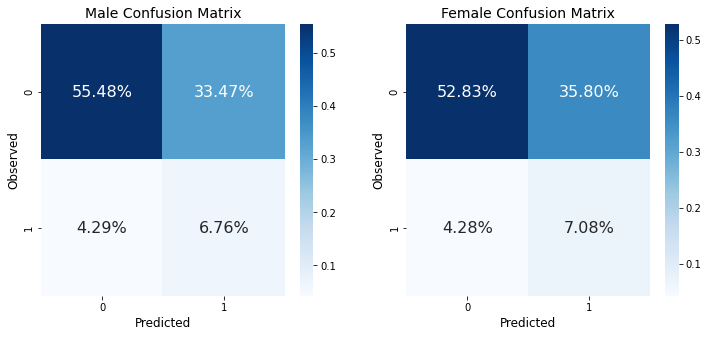

In [ ]:
_ = compare_confusion_matrices(y_test[X_test['gender_Male']==1], y_pred[X_test['gender_Male']==1],\
                           y_test[X_test['gender_Female']==1], y_pred[X_test['gender_Female']==1],\
                           'Male', 'Female')

**몇 가지 의학적 특징을 통한 분석**

아마도 몇몇 의학적 특징은 인구 통계학적 특징보다 더 뚜렷한 차이가 있을 수도 있다.

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='admission_source_id')

Error breakdown for group 'admission_source_id'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
admission_source_id,,,,,,,,
Emergency,"17,228",57.9%,16.9%,65.7%,26.9%,64.9%,34.3%,43.1%
Referral,"9,303",64.9%,16.8%,56.7%,25.9%,65.1%,43.3%,34.1%
Other,"3,999",65.2%,14.8%,54.8%,23.3%,64.0%,45.2%,33.7%


In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='had_inpatient_days')

Error breakdown for group 'had_inpatient_days'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
had_inpatient_days,,,,,,,,
False,"20,292",79.1%,14.6%,30.4%,19.7%,62.8%,69.6%,16.4%
True,"10,238",25.1%,17.4%,93.4%,29.4%,57.4%,6.6%,88.5%


꽤 명확하게 보인다.. 
무슨 일이 일어나고 있는지 이해하기 위해 이것을 비교해보자.

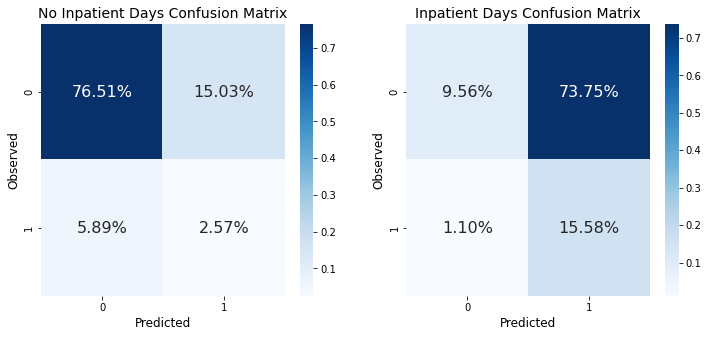

In [ ]:
_ = compare_confusion_matrices(y_test[X_test['had_inpatient_days']==0], y_pred[X_test['had_inpatient_days']==0],\
                           y_test[X_test['had_inpatient_days']==1], y_pred[X_test['had_inpatient_days']==1],\
                           'No Inpatient Days', 'Inpatient Days', compare_fpr=True)

30일 이후 재입원을 포함하지 않는 하위 집합이 유사한 `Confusion Matrix`를 갖는지 보자.

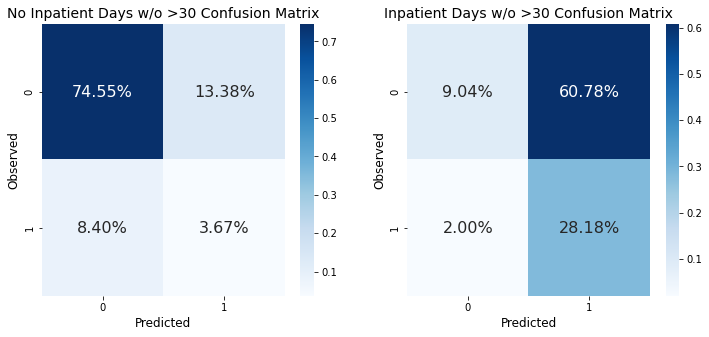

In [ ]:
_ = compare_confusion_matrices(y_test[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')],\
                           y_test[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')],\
                           'No Inpatient Days w/o >30', 'Inpatient Days w/o >30', compare_fpr=True)

# 🥇Session 3 - 「주제그룹 분석」

## 3) Feature Importance and More Advanced Error Analysis

### 3-1. Sample data

In [ ]:
X_test_sample = X_test[(X_orig_test['readmitted']!='>30')].sample(frac=0.1)
y_test_sample = y_test.loc[X_test_sample.index]

y_prob_sample = clf.predict_proba(X_test_sample)[:,1]
y_pred_sample = np.where(y_prob_sample > 0.5, 1, 0)

In [ ]:
X_test_sample

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
20489,5.0,42.0,1.0,10.0,9.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
953,3.0,60.0,0.0,10.0,7.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
3714,13.0,75.0,6.0,28.0,9.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
18373,5.0,41.0,2.0,20.0,9.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
50628,2.0,35.0,0.0,15.0,4.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52935,8.0,55.0,1.0,14.0,7.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
61979,3.0,47.0,0.0,9.0,5.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1
81860,3.0,45.0,0.0,14.0,9.0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
66276,3.0,62.0,0.0,17.0,7.0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1


### 3-2. SHAP values 생성하기

In [ ]:
%%time
shap_explainer = shap.Explainer(clf, X_train)
shap_values = shap_explainer(X_test_sample)

CPU times: user 3.67 s, sys: 24.1 ms, total: 3.7 s
Wall time: 3.69 s


In [ ]:
shap_values.values

array([[ 0.02884155,  0.04117571,  0.00582015, ...,  0.        ,
         0.01522815,  0.        ],
       [ 0.01133818,  0.01394931,  0.01124005, ...,  0.        ,
         0.01518547,  0.        ],
       [ 0.09176146, -0.14750104, -0.02069468, ...,  0.        ,
         0.02883579,  0.        ],
       ...,
       [-0.00901874,  0.05642733,  0.01686954, ...,  0.        ,
         0.03891888,  0.        ],
       [-0.01683853,  0.10022285,  0.00319067, ...,  0.        ,
         0.0367508 ,  0.        ],
       [ 0.02455909, -0.02551568, -0.00336406, ...,  0.        ,
         0.01878752,  0.        ]])

In [ ]:
print(shap_values.values.shape)

(1989, 54)


### 3-3. Feature Importance Plots

한 축에서 SHAP 값의 절대값을 평균화하면 기능 중요도 측정값(Feature당 하나)

In [ ]:
np.abs(shap_values.values).mean(axis=0)

array([0.0430979 , 0.00932848, 0.        , 0.01689199, 0.04168366,
       0.        , 0.        , 0.03568738, 0.26897323, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1460471 , 0.        , 0.        ,
       0.00228608, 0.        , 0.00976443, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00471641, 0.        , 0.02813933, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00569378,
       0.        , 0.02230928, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03232883, 0.        ])

이 함수는 각 Feature의 Importance 순위 표시

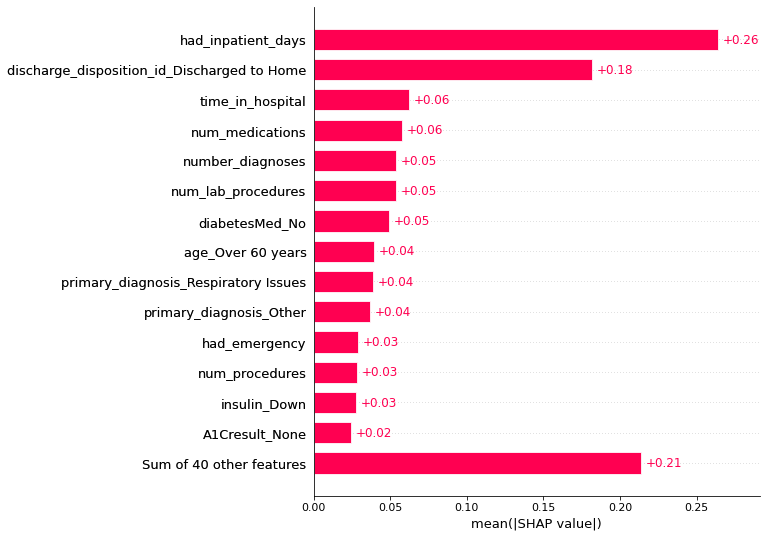

In [ ]:
shap.plots.bar(shap_values, max_display=15)

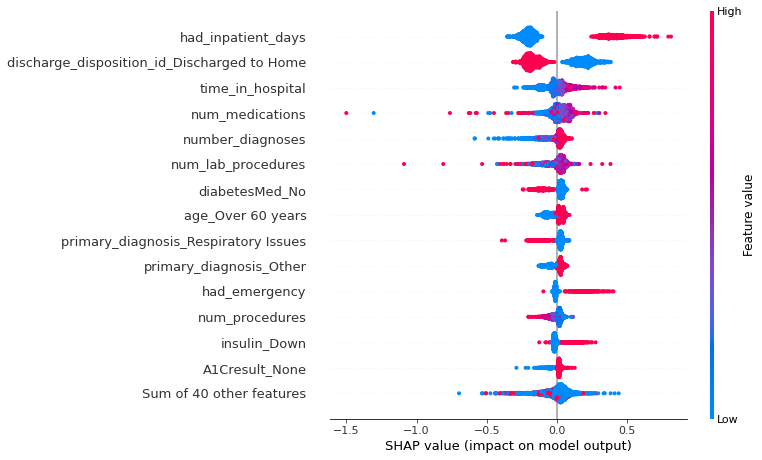

In [ ]:
shap.plots.beeswarm(shap_values, max_display=15)

### 3-4. Scatter Plots

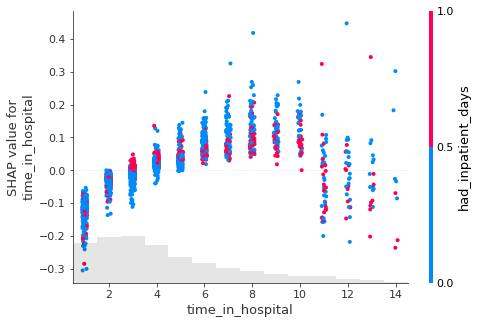

In [ ]:
shap.plots.scatter(shap_values[:,"time_in_hospital"],\
                   color=shap_values[:,"had_inpatient_days"])

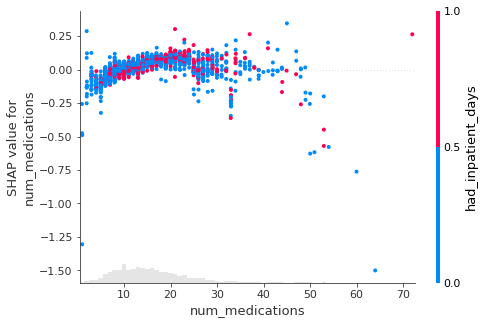

In [ ]:
shap.plots.scatter(shap_values[:,"num_medications"],\
                   color=shap_values[:,"had_inpatient_days"])

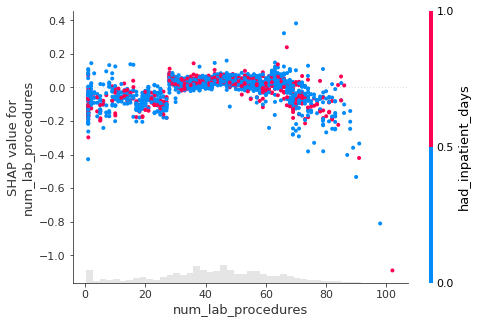

In [ ]:
shap.plots.scatter(shap_values[:,"num_lab_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

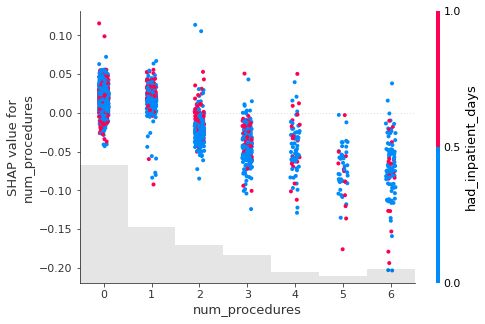

In [ ]:
shap.plots.scatter(shap_values[:,"num_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

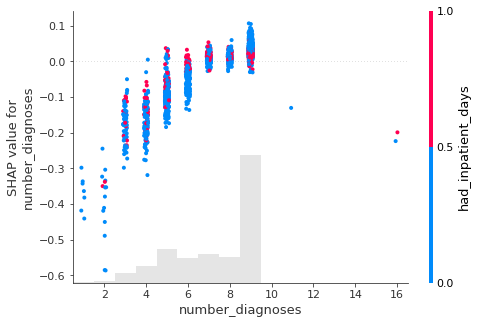

In [ ]:
shap.plots.scatter(shap_values[:,"number_diagnoses"], color=shap_values[:,"had_inpatient_days"])

### 3-5. 에러를 줄이는 몇 가지 전략

#### 3-5-1. Post-processing (predictions)

이것은 일종의 편법이라고 생각할 수도 있지만 Positive 클래스를 예측하는 경우에 대한 임계값 조절하는 것은 일반적인 일이다. 임계값이 일관되게 0.5일 필요는 없다. 에러를 최소화하기 위해 확률 자체를 보정하는 경우도 있다.

In [ ]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'had_inpatient_days':X_test['had_inpatient_days'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred,
                         'y_prob':y_prob})
preds_df = preds_df[(preds_df['readmitted']!='>30')]

preds_df['y_pred_new'] = np.where(preds_df.had_inpatient_days==0,\
                                  np.where(preds_df.y_prob > 0.45, 1, 0),
                                  np.where(preds_df.y_prob > 0.59, 1, 0))

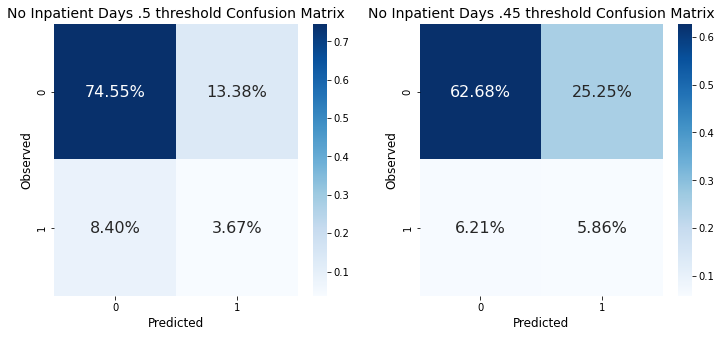

In [ ]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred_new'],
                               'No Inpatient Days .5 threshold', 'No Inpatient Days .45 threshold')

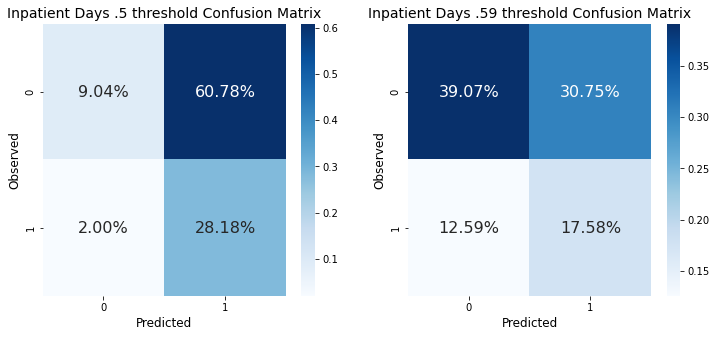

In [ ]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred_new'],
                               'Inpatient Days .5 threshold', 'Inpatient Days .59 threshold')

#### 3-5-2. In-processing (model)

- `sample_weight` 혹은 다양한 `sampling` 기법을 사용하여 모델이 가장 못 맞추는 샘플에 더 집중하도록 한다.
- 코호트에 따라 `False Negative`를 다르게 패널티화하는 맞춤형 `loss function` 활용
- 대신 다중 클래스 분류 모델을 사용해보자. 아마도 `NO`와 `>30`을 분리하면 모델의 성능이 향상될 수 있다.

#### 3-5-3. Pre-processing (data)

- 도메인 전문가와 함께 에러를 검토하고 더 잘 분류하는 데 도움이 될 수 있는 새로운 Feature를 찾아보는게 좋다.
- 이전에 엔지니어링된 일부 Feature가 특징을 잘 분류할 수 있는 특성이 엔지니어링 과정에서 사라졌을 수도 있다. 예를 들어 연령은 연령 그룹에 있지만 더 작은 그룹 또는 실제 연령으로 사용한다면 오류가 더 줄어들 것입니다. (대신 연산량이 많아짐)